# Predicción precio vivienda con RNA

Usaremos el set de datos SaratogaHouses del paquete mosaicData de R.  Incluye información de más de 1700 viviendas de NY (Estados Unidos) recogiendo información de 15 variables:

    price: precio de la vivienda.
    lotSize: metros cuadrados de la vivienda.
    age: antigüedad de la vivienda.
    landValue: valor del terreno.
    livingArea: metros cuadrados habitables.
    pctCollege: porcentaje del vecindario con título universitario.
    bedrooms: número de dormitorios.
    firplaces: número de chimeneas.
    bathrooms: número de cuartos de baño (el valor 0.5 hace referencia a cuartos de baño sin ducha).
    rooms: número de habitaciones.
    heating: tipo de calefacción.
    fuel: tipo de alimentación de la calefacción (gas, electricidad o diesel).
    sewer: tipo de desagüe.
    waterfront: si la vivienda tiene vistas al lago.
    newConstruction: si la vivienda es de nueva construcción.
    centralAir: si la vivienda tiene aire acondicionado.


Veamos si podemos modelar el precio del alquiler en base a dichos datos y variables

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

from sklearn.neural_network import MLPRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn import set_config
import multiprocessing

import warnings
warnings.filterwarnings('ignore')

import os

In [42]:
os.chdir (os.getcwd())

In [43]:
#os.chdir (r"/datos")
df = pd.read_csv("datos/saratogaHousing.csv")

In [44]:
df

,price,lotSize,age,landValue,livingArea,pctCollege,bedrooms,fireplaces,bathrooms,rooms,heating,fuel,sewer,waterfront,newConstruction,centralAir
0,132500,0.09,42,50000,906,35,2,1,1.0,5,electric,electric,septic,No,No,No
1,181115,0.92,0,22300,1953,51,3,0,2.5,6,hot water/steam,gas,septic,No,No,No
2,109000,0.19,133,7300,1944,51,4,1,1.0,8,hot water/steam,gas,public/commercial,No,No,No
3,155000,0.41,13,18700,1944,51,3,1,1.5,5,hot air,gas,septic,No,No,No
4,86060,0.11,0,15000,840,51,2,0,1.0,3,hot air,gas,public/commercial,No,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723,289000,0.38,32,24200,2310,61,5,1,2.5,11,hot water/steam,gas,public/commercial,No,No,No
1724,285000,0.94,37,36200,2564,61,4,1,2.5,11,hot water/steam,gas,public/commercial,No,No,No
1725,194900,0.39,9,20400,1099,51,2,0,1.0,3,hot air,gas,public/commercial,No,No,No
1726,125000,0.24,48,16800,1225,51,3,1,1.0,7,hot air,gas,public/commercial,No,No,No


In [45]:
# Renombramos las columnas
df.columns = ["precio", "metros_totales", "antiguedad", "precio_terreno",
                 "metros_habitables", "universitarios", "dormitorios", 
                 "chimenea", "banyos", "habitaciones", "calefaccion",
                 "consumo_calefacion", "desague", "vistas_lago",
                 "nueva_construccion", "aire_acondicionado"]

### EDA

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   precio              1728 non-null   int64  
 1   metros_totales      1728 non-null   float64
 2   antiguedad          1728 non-null   int64  
 3   precio_terreno      1728 non-null   int64  
 4   metros_habitables   1728 non-null   int64  
 5   universitarios      1728 non-null   int64  
 6   dormitorios         1728 non-null   int64  
 7   chimenea            1728 non-null   int64  
 8   banyos              1728 non-null   float64
 9   habitaciones        1728 non-null   int64  
 10  calefaccion         1728 non-null   object 
 11  consumo_calefacion  1728 non-null   object 
 12  desague             1728 non-null   object 
 13  vistas_lago         1728 non-null   object 
 14  nueva_construccion  1728 non-null   object 
 15  aire_acondicionado  1728 non-null   object 
dtypes: flo

Todos las columnas tienen los tipos correctos

In [47]:
df.isna().sum().sort_values()

precio                0
metros_totales        0
antiguedad            0
precio_terreno        0
metros_habitables     0
universitarios        0
dormitorios           0
chimenea              0
banyos                0
habitaciones          0
calefaccion           0
consumo_calefacion    0
desague               0
vistas_lago           0
nueva_construccion    0
aire_acondicionado    0
dtype: int64

No tenemos problemas de completitud

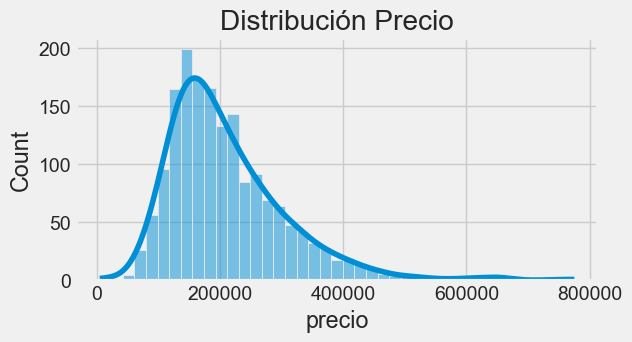

In [48]:
# Comprobamos cómo se distruyen los datos de precio de venta

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
sns.histplot(df, x='precio', kde=True,ax=ax)
sns.set_style("white")
ax.set_title("Distribución Precio")
ax.set_xlabel('precio');

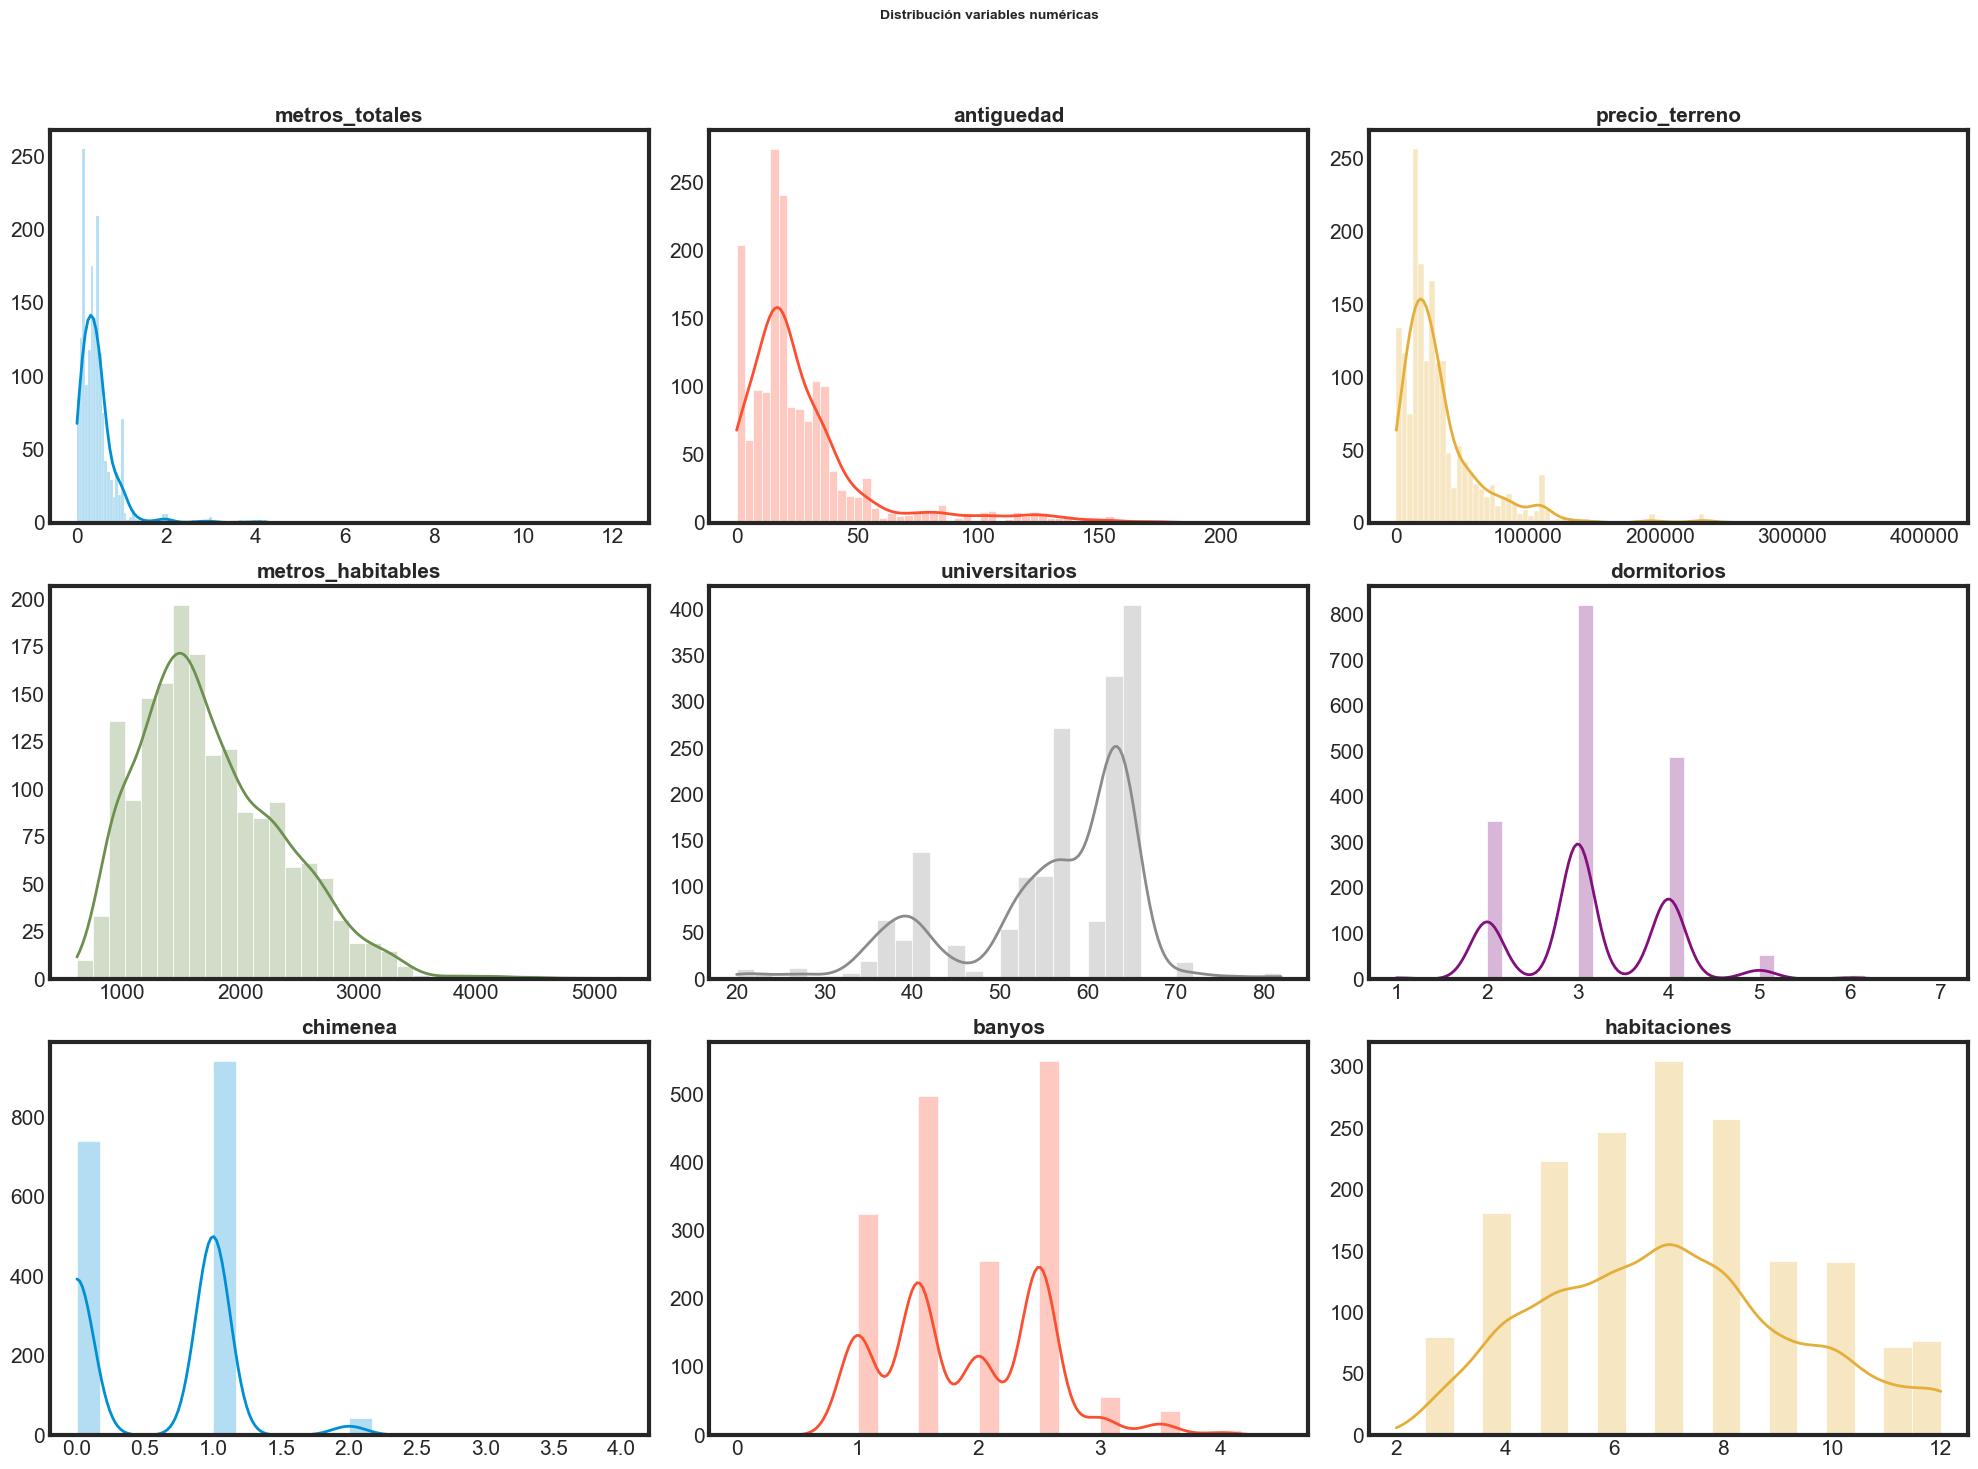

In [49]:
# Pintamos las variables numéricas

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))
axes = axes.flat
columnas_numeric = df.select_dtypes(include=['float64', 'int']).columns
columnas_numeric = columnas_numeric.drop('precio')

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = df,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 15)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 10, fontweight = "bold");

La variable chimenea adopta pocos estados, en casos como éstos es conveniente tratarla como categórica.

In [50]:
df.chimenea = df.chimenea.astype("str")
df.chimenea.value_counts()

1    942
0    740
2     42
4      2
3      2
Name: chimenea, dtype: int64

In [51]:
# Comprobamos y pintamos las variables categóricas
df.select_dtypes(include=['object']).describe()

,chimenea,calefaccion,consumo_calefacion,desague,vistas_lago,nueva_construccion,aire_acondicionado
count,1728,1728,1728,1728,1728,1728,1728
unique,5,3,3,3,2,2,2
top,1,hot air,gas,public/commercial,No,No,No
freq,942,1121,1197,1213,1713,1647,1093


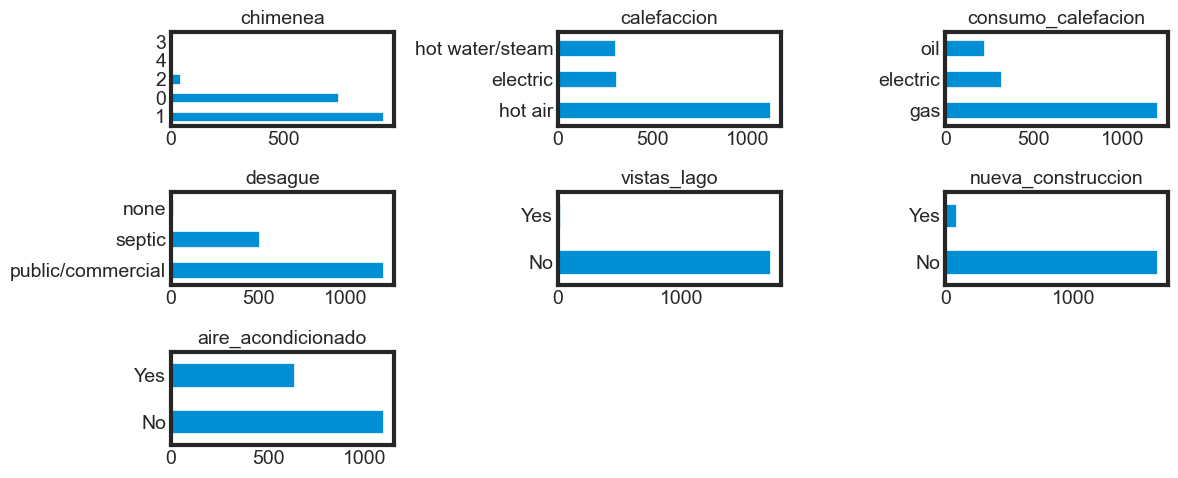

In [52]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 5))
axes = axes.flat
columnas_object = df.select_dtypes(include=['object']).columns

for i, colum in enumerate(columnas_object):
    df[colum].value_counts().plot.barh(ax = axes[i])
    axes[i].set_title(colum, fontsize = 14)
    axes[i].set_xlabel("")

# Se eliminan los axes vacíos
for i in [7, 8]:
    fig.delaxes(axes[i])
    
fig.tight_layout()


Si alguno de los niveles de una variable cualitativa tiene muy pocas observaciones en comparación a los otros niveles, puede ocurrir que, durante la validación cruzada o bootstrapping, algunas particiones no contengan ninguna observación de dicha clase (varianza cero), lo que puede dar lugar a errores. Para este caso, hay que tener precaución con la variable chimenea. Se unifican los niveles de 2, 3 y 4 en un nuevo nivel llamado "2_mas".

In [53]:
mapeo = {'2': "2_mas",
               '3': "2_mas",
               '4': "2_mas"}

df['chimenea'] = df['chimenea'] .map(mapeo).fillna(df['chimenea'])

df.chimenea.value_counts().sort_index()


0        740
1        942
2_mas     46
Name: chimenea, dtype: int64

### División de los datos en Train y Test

In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
                                        df.drop('precio', axis = 'columns'),
                                        df['precio'],
                                        train_size   = 0.7,
                                        random_state = 123,
                                        shuffle      = True
                                    )

In [55]:
print("Partición de entrenamento")
print("-----------------------")
display(y_train.describe())
display(X_train.describe())
display(X_train.describe(include = 'object'))
print(" ")

print("Partición de test")
print("-----------------------")
display(y_test.describe())
display(X_test.describe())
display(X_test.describe(include = 'object'))

Partición de entrenamento
-----------------------


count      1209.000000
mean     212474.237386
std       97233.331785
min        5000.000000
25%      145000.000000
50%      191500.000000
75%      259900.000000
max      775000.000000
Name: precio, dtype: float64

,metros_totales,antiguedad,precio_terreno,metros_habitables,universitarios,dormitorios,banyos,habitaciones
count,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000
mean,0.510993,26.751034,34671.025641,1778.014888,55.506203,3.167907,1.923904,7.097601
std,0.731041,28.285677,34460.420428,636.602289,10.214999,0.817298,0.658301,2.365677
min,0.010000,0.000000,200.000000,616.000000,20.000000,1.000000,1.000000,2.000000
25%,0.170000,12.000000,15100.000000,1304.000000,52.000000,3.000000,1.500000,5.000000
50%,0.370000,19.000000,25000.000000,1656.000000,57.000000,3.000000,2.000000,7.000000
75%,0.530000,33.000000,42000.000000,2185.000000,63.000000,4.000000,2.500000,9.000000
max,12.200000,225.000000,250000.000000,5228.000000,82.000000,7.000000,4.500000,12.000000


,chimenea,calefaccion,consumo_calefacion,desague,vistas_lago,nueva_construccion,aire_acondicionado
count,1209,1209,1209,1209,1209,1209,1209
unique,3,3,3,3,2,2,2
top,1,hot air,gas,public/commercial,No,No,No
freq,667,779,842,853,1202,1149,761


 
Partición de test
-----------------------


count       519.000000
mean     210784.420039
std      101285.133770
min       20000.000000
25%      145000.000000
50%      185000.000000
75%      255000.000000
max      775000.000000
Name: precio, dtype: float64

,metros_totales,antiguedad,precio_terreno,metros_habitables,universitarios,dormitorios,banyos,habitaciones
count,519.000000,519.000000,519.000000,519.000000,519.000000,519.000000,519.000000,519.000000
mean,0.475106,30.630058,34292.003854,1701.306358,55.710983,3.123314,1.844894,6.911368
std,0.616682,31.116823,36326.430790,576.279936,10.613302,0.817412,0.655779,2.194202
min,0.000000,0.000000,600.000000,672.000000,20.000000,1.000000,0.000000,3.000000
25%,0.170000,14.000000,15150.000000,1291.000000,52.000000,3.000000,1.500000,5.000000
50%,0.380000,19.000000,25000.000000,1604.000000,60.000000,3.000000,1.500000,7.000000
75%,0.565000,35.000000,38050.000000,2073.000000,64.000000,4.000000,2.500000,8.000000
max,8.970000,169.000000,412600.000000,4128.000000,82.000000,7.000000,4.000000,12.000000


,chimenea,calefaccion,consumo_calefacion,desague,vistas_lago,nueva_construccion,aire_acondicionado
count,519,519,519,519,519,519,519
unique,3,3,3,3,2,2,2
top,1,hot air,gas,public/commercial,No,No,No
freq,275,342,355,360,511,498,332


### Preprocesado y modelado

In [21]:
# Identificación de columnas numéricas y categóricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()


# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())])

# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                            steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Para tener en cuenta aquellas columnas que no requieren transformación, necesitamos usar el argumento reminder=passthrough
preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)],
                    remainder='passthrough')

# Combinamos los pasos de preprocesado y el modelo en un mismo pipeline
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', MLPRegressor(solver = 'lbfgs', max_iter= 6000))])

### Validación cruzada y búsqueda de hiperparámetros

In [56]:
hiperparametros = {
    'modelo__hidden_layer_sizes': [(10), (20), (10, 10)],
    'modelo__alpha': np.logspace(-3, 3, 10),
    'modelo__learning_rate_init': [0.001, 0.01]
}


In [57]:
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = hiperparametros,
        n_iter     = 150,
        scoring    = 'neg_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = 5, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True)

grid.fit(X = X_train, y = y_train)

# Nota: Se utiliza la versión negativa del error cuadrático medio para que cuanto mayor 
# sea el valor devuelto por la función de pérdida, peor sea la calidad del modelo. 
# Esto se debe a que en la mayoría de los casos, se espera que un modelo de regresión 
# produzca una salida numérica que sea lo más cercana posible al valor real. 
# Por lo tanto, cuanto mayor sea el error cuadrático medio, mayor será la discrepancia
# entre los valores reales y los predichos.

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('numeric',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['metros_totales',
                                                                                'antiguedad',
                                                                                'precio_terreno',
                                                                                'metros_habitables',
                                                                                'universitarios',
                     

### Resultados y evaluación final

In [58]:
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)').drop(columns = 'params').sort_values('mean_test_score', ascending = False).head(10)

,param_modelo__learning_rate_init,param_modelo__hidden_layer_sizes,param_modelo__alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
7,0.01,10,0.004642,-3.162168e+09,2.605962e+08,-2.553753e+09,2.371910e+08
12,0.001,10,0.021544,-3.244926e+09,2.857397e+08,-2.448052e+09,1.393194e+08
13,0.01,10,0.021544,-3.307811e+09,3.470649e+08,-2.573317e+09,3.459635e+08
22,0.001,"(10, 10)",0.1,-3.331515e+09,4.319545e+08,-2.227765e+09,1.090026e+08
6,0.001,10,0.004642,-3.337615e+09,4.629977e+08,-2.389943e+09,1.192892e+08
58,0.001,"(10, 10)",1000.0,-3.342404e+09,3.002486e+08,-2.194224e+09,1.661140e+08
30,0.001,10,2.154435,-3.360866e+09,3.555863e+08,-2.182499e+09,1.329243e+08
31,0.01,10,2.154435,-3.361893e+09,3.098589e+08,-2.320343e+09,9.323401e+07
48,0.001,10,215.443469,-3.394879e+09,1.435989e+08,-2.318561e+09,2.183553e+08
24,0.001,10,0.464159,-3.404687e+09,3.199774e+08,-2.391454e+09,1.194072e+08


In [59]:
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test)
rmse = mean_squared_error(
        y_true = y_test,
        y_pred = predicciones,
        squared = False
       )
print('Error de test (rmse): ', rmse)

Error de test (rmse):  67998.42577244875


In [60]:
modelo_final['modelo'].get_params()

{'activation': 'relu',
 'alpha': 0.004641588833612777,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': 10,
 'learning_rate': 'constant',
 'learning_rate_init': 0.01,
 'max_fun': 15000,
 'max_iter': 6000,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}